# MODEL I - Basal Ganglia Model : MSN-GPe-FSI (2017)

In [1]:
# To launch the simulation, run all cells once.

#  - Import modules -

In [2]:
import os, time, random, json               # Utility: create, save and store the data.
import numpy as np                          # Utility: for everything.
import scipy.stats as stats                 # Utility: fourier transform.
from tqdm import tqdm                       # Utility: show a progress bar below the simulation core.

In [3]:
from matplotlib import pyplot as plt        # Utility: for the plots, using "plt" extension. 
import matplotlib                           # Utility: imported to enhance the ticks & labelsize of all plots.
matplotlib.rc('xtick', labelsize=20)        # Utility: enhance x-ticks visibility.
matplotlib.rc('ytick', labelsize=20)        # Utility: enhance y-ticks visibility.
plt.rcParams["axes.labelweight"] = "bold"   # Utility: axis label made bold (better visibility).

#  - Function definitions -

# 1 - Corrected Input

In [4]:
 ## Function returning the corrected Input (x = 0 if x <= 0  or  x = x if x >= 0)

def Ic(Input = 0):                          # the only argument is the input value. 
    
    """ 
    Use as argument the input value and 
    the fonction will transform any negative Input value 
    to zero whereas any positive Input value won't be transformed. 
    
    """
    
    
    if Input <= 0:                          # if input value is negative,  
        return 0                            # function return 0.
    
    else:                                   # if input value is not negative, the function  
        return (Input)                      # just return the input value.

# 2 - Activity value at time (t - Δ)

In [5]:
 ## Function to get the activity value at time (t - delta)

def delta(synapse_value, delay, t, dt,i): 
    
    """ 
    The first argument is the array (1D) containing all the activity values trought the time, 
    for solely one population. The second argument is the time delay, the third is the time, 
    the fourth is the time step used for the simulation, the fifth is the neuron number for 
    multiple neuron simulations with 2D array (Activity at time t x neuron number). 
    
    """
    
    
    if t < delay:                                        # if delay > time simulation, m(t-delta) = 0
        return 0
    
                                                         # Otherwise we can find the m(t-delta) value by taking
    else:                                                # the (delay/dt)th value, starting from the value at
        return synapse_value[ int(- delay / dt) ][i]     # time t (last value calculated in the array).
                                                         # [i] is the neuron number.
                                                         # (delay/dt) give the step number 
                                                         # between m(t) and m(t-delta)

# 3 - Plotting: Inputs & activities

In [6]:
 ## Plot the external Inputs in an horizontal bar chart plot 

def Inplot(x,data,title):
    
    """ Make an histogram of a set of data given (2nd argument). The first argument 'structure' is
    the structures we want to represent(array). the 3rd argument is the title of the plot(string).
    
    """

    
    ind  =    np.arange(len(data))                                      # number of groups
    fig  =    plt.figure()                                              # set the frame plot
    ax   =    plt.subplot(111)                                          # set the subplot
    
    ax.barh(ind, data, 0.899,color='g')                                 # Plotting the data with bar
    ax.set_yticks(ind)                                                  # name the y-axis label
    
    r    =    ax.set_yticklabels(x, ha = 'left',fontsize = 16)
    fig.set_size_inches(15, 2, forward=True)
    
    plt.draw()
    yax  =    ax.get_yaxis()
    pad  =    max(T.label.get_window_extent().width for T in yax.majorTicks)
    yax.set_tick_params(pad=pad,)
    

    plt.xlabel('spike per second [spk/s]')                                    # Set the x-axis label
    plt.ylabel('structures')                                                  # Set the y-axis label
    plt.title('External Input value for each structure')                      # Set the plot title
    
    plt.savefig('DataFsi/{}/0_H.png'.format(timestr),dpi=72,bbox_inches='tight') # Save figure (72 DPi) in timestr 
                                                                                 # folder (Cf. Data_dir function)

In [7]:
 ## Plot activity or input dynamics depending on arguments

def plotting(k,typ, title, xax, yax, element, source, value, On): 
    
    """ 
    'k' argument is the neuron number (index) to know which neuron of all populations to plot, 
    'typ' argument is the kind (dictionnary) of value to look at (e.g., 'm' for activity or 'I' for input).  
    'title' argument is the plot title (string), 'xax' and 'yax' are the x-axis and y-axis label(string)
    ,respectively. the 'element' argument(e.g., con, stc) is the index of the 'source'(array) 
    argument(e.g. connections,structures). The 'value' argument is the dictionnary where to store 
    the processed value(e.g. 'value' or 'Mean'). On = 1 to take the mean of the data, On = 0 otherwise. 
    
    """
    
    
    fig = plt.figure(figsize=(15,10))                        # Set the global figure and choose the size.
    ax=fig.add_subplot(111)                                  # Set a subplot.
    
    
    for element in source:                                   # for every element in array source,
        value[element]=np.zeros(n_period)                    # it creates an array of zeros x n_period, 
                                                             # with the "element" as key
        for t in range(0,n_period):
                                                             # for all time step of the simulation.
            if On == 0:                                      # If On = 0, 
                value[element][t] = typ[element][t][k]       # we put the value of neuron k at time t 
                
            else:                                            # in the array created above for each time.
                value[element][t] = np.mean(typ[element][t]) # If On = 1, we take the mean of all the neuron at 
                                                             # time t.

                
        ax.plot(time_value*1000, value[element], label= str(element),linewidth=2)  # plotting x = f(t)
        ax.set_title((title + ' {}'.format(k+1)))                                  # Set the title w/ neuron number
        ax.set_ylabel(yax), ax.set_xlabel(xax)                                         # Set the y & x -axis label
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size':15})   # Set a legend, its location
                                                                                       # & size (for labels). 

# 4 - Creating data folder

In [8]:
 ## Will create the folders needed to store values in CWD/Data pathway

def data_dir(dir="os.getcwd()"):
    
    """ 
    The only argument is the pathway to look in, by default the current working directory.
    This function is aimed to create a folder "Data" in the current working directory (CWD) to store all
    our results in. If the folder is already created, no new folder is added. The second part of 
    the function use the real computer time to tag a newly created folder in "Data" folder.
    timestr is the date and time (yyyy-mm-dd-HH:MM:SS). At each new simulation trial, a new tagged folder
    is created in the "Data" folder of the CWD.
    
    """
    
    
    if not os.path.exists('{}/{}'.format(os.getcwd(),'DataFsi')): # If no "DataFsi" folder exist in the CWD, 
        directory = os.path.dirname(dir)
        os.makedirs('{}/{}'.format(os.getcwd(),'DataFsi'))        # it will create it. 
        
                                                                 # timestr will be used to tag simulation results
    if not os.path.exists('DataFsi/{}'.format(timestr)):         # folder. If no folder with the current 
        os.makedirs('DataFsi/{}'.format(timestr))                # time launch simulation is already created,
                                                                 # it will create it.  

# 5 - Spectral analysis & plotting function

In [9]:
 ## Plot the spectrum of all populations and return their plot 

def Spectrum(): 
    
    """ 
    Use the mean activities of all neurons over time and give the spectrum/frequency 
    analysis of the signal with a plot for all populations. 
    
    """
    
    
    col=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']     # Array containing color "code".
    
    FourNormalized =    dict()                                           # Create some dictionnary to store the 
    fourier        =    dict()                                           # values of the FFT.
    freq           =    dict()

    fig, axes = plt.subplots(1, 3, figsize=(30, 9))                      # Set the frame & size of the futur plot.
    fig.suptitle("Discrete fourier transform of Outputs",y=1.05, fontsize=20)
    i=0                                                                  # Just count the number of iteration to
                                                                         # select a color for plotting.
    for con in connections:                                              
        
        FourNormalized[con] = Mean[con] - np.mean(Mean[con])

 # Fast Fourrier Transform of signal
        fourier[con]  =  np.fft.fft(FourNormalized[con]) / len(FourNormalized[con])
        freq[con]     =  np.fft.fftfreq(fourier[con].shape[0],dt)

        toc = np.argmax(abs(fourier[con]))                               # we take the maximum value
                                                                         # (dominant frequency)
 # Plotting FFT of signal
        axes[i].plot(freq[con],abs(fourier[con]),label=str(abs(freq[con][toc]))+' Hz',     # Plotting the results
                 color=col[i+2],linewidth=3)                                               
        axes[i].set_title(con,fontsize=20)
        axes[i].set_xlabel('spectrum range [Hz]', fontsize=18)
        axes[i].set_xlim(0,50)
        axes[i].set_ylabel('Amplitude (normalized)',fontsize=18)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
        axes[i].legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0. , fontsize=20)
        i+=1
            
    plt.savefig('DataFsi/{}/FFT_{}72.png'.format(timestr,'Mean'),dpi=72,bbox_inches='tight')

#  - Initial parameters - 

# 1 - Initialisation : optimisation tools

In [10]:
 ## Initialization of the random generator (reproductibility)

w           =        np.random.randint(1,10)        # we choose a random number to be used as seed
                                                    # and saved (Json) for reproductibility.
np.random.seed(w)                                   # Initialisation of the random generator.

In [11]:
 ## Dictionnary to store Mean, m, dm, J, y, value, H and I values

Mean, m, dm, I  =    dict(), dict(), dict(), dict() # Dictionnary used to store our values and make easier
J, H, y, value  =    dict(), dict(), dict(), dict() # the call of a particular value with keys.
T               =    dict()                         # T will be used to store the threshold distribution

In [12]:
 ## creation of a set of structures and connections : model architecture 

connections =        ["GpeMsn", "FsiGpe", "MsnFsi"] # Set the connections names in an array to call them easily.
structures  =        ["Msn", "Fsi", "Gpe"]          # Set the structures names in an array to call them easily.

In [13]:
 ## Define the mapping for inputs and activities dynamic equations (Cf. equations or simulation core)

input_mapping = {                    # Inputs in one population depend on the upstream connections. 
    
    "Msn" :         "MsnFsi",        # MSN input value depend on FSI to MSN connections.
    "Gpe" :         "GpeMsn",        # GPe input value depend on MSN to GPe connections.
    "Fsi" :         "FsiGpe"         # FSi input value depend on GPe to FSi connections.
}


                                      
activities_mapping = {               # Activities in one population depend on the upstream Inputs.
    
    "GpeMsn" :      "Msn",           # MSN to GPe activity value depend on MSN inputs.
    "FsiGpe" :      "Gpe",           # GPe to FSi activity value depend on GPe inputs.
    "MsnFsi" :      "Fsi"            # FSi to MSN activity value depend on FSI inputs.
}

# 2 - Setting parameters

In [14]:
 ## Population size 
n           =        1                              # Number of neurons in each populations.

 ## Simulation duration
duration    =        1.00                           # Total time of the simulation (sec).

 ## Time resolution
dt          =        0.0001                         # Time step (sec).

 ## Period occuring 
n_period    =        int(duration / dt)             # Total number of step during the simulation. 

In [15]:
 ## Time array generation

time_value  =        np.arange(0, duration, dt)     # Array containing all discrete time.

In [16]:
 ## Weights of connections (connexion pre -> post ; notation: PostPre):
    
G = {
    
    "GpeMsn" :       1.00,                          # connexion weight between MSN & Gpe (dimensionless).
    "FsiGpe" :       1.00,                          # connexion weight between Gpe & Fsi (dimensionless).
    "MsnFsi" :       1.00                           # connexion weight between FSi & MSN (dimensionless).
}

In [17]:
 ## Fixed point activity of neurons (from papers):
    
M = {    
    
    "GpeMsn" :       3,                             # MSN neurons resting activity : 3  (spikes/sec).
    "MsnFsi" :       5,                             # FSI neurons resting activity : 5  (spikes/sec).
    "FsiGpe" :       20                             # GPe neurons resting activity : 20 (spikes/sec).
}

In [18]:
 ## Time decay constant, Tau, of neurons (from papers):
    
tau = {
    
    "GpeMsn" :       0.020,                         # MSN time decay constant  : 0.020 (sec).
    "FsiGpe" :       0.005,                         # GPe time decay constant  : 0.005 (sec).
    "MsnFsi" :       0.005                          # FSi time decay constant  : 0.005 (sec).
}

In [19]:
 ## Delays 'delta' of signal transmission between two connected populations (from papers):
    
D = {
    
    "GpeMsn" :       0.0070,                        # MSN to GPe delay : 0.007 (sec) ; (Jaeger & Kita, 2011).
    "FsiGpe" :       0.0010,                        # GPe to FSi delay : 0.001 (sec) ; (Jaeger & Kita, 2011).
    "MsnFsi" :       0.0008                         # FSi to MSN delay : 0.008 (sec) ; (Gittis et al., 2010).
}

In [20]:
 ## Connection probability between two connected populations :
    
C = {
    
    "GpeMsn" :       1.00,                          # MSN to GPe connection probability : 0.048 (Str-GPi).
    "FsiGpe" :       1.00,                          # GPe to FSi connection probability : Unknown.
    "MsnFsi" :       1.00                           # FSi to MSN connection probability : 1 (all-to-all).
}

In [21]:
 ## External Input: calculated from dynamic equations and constant during the whole simulation:
    
H = {
    
    "Msn" :          M['GpeMsn'] + G['MsnFsi'] * M['MsnFsi'],   # External Input on MSN neurons (spikes/sec).
    "Fsi" :          M['MsnFsi'] + G['FsiGpe'] * M['FsiGpe'],   # External Input on FSi neurons (spikes/sec).
    "Gpe" :          M['FsiGpe'] + G['GpeMsn'] * M['GpeMsn']    # External Input on GPe neurons (spikes/sec).
}

In [22]:
 ## Noise(sigma): set the noise from a centered gaussian distribution 
 ## with a standard deviation (SD) defined below:    

N = {                                               # Set to '0' to fully eliminate the noise from a population.
    
    "Msn" :          H['Msn'] / 5,                  # Noise SD for MSN neurons (spikes/sec).              
    "Fsi" :          H['Fsi'] / 5,                  # Noise SD for FSi neurons (spikes/sec).
    "Gpe" :          H['Gpe'] / 5                   # Noise SD for GPe neurons (spikes/sec).
}

In [23]:
 ## Threshold distribution (sigma): set the threshold distribution from a centered gaussian distribution 
 ## with a standard deviation (SD) defined below:    
    
TN = {                                              # Set to '0' to fully eliminate the heterogeneity
                                                    # from a population.
    "Msn" :          H["Msn"],                      # Threshold distribution SD for MSN neurons (spikes/sec).
    "Fsi" :          1,                             # Threshold distribution SD for FSi neurons (spikes/sec).
    "Gpe" :          1                              # Threshold distribution SD for GPe neurons (spikes/sec).
}

# 3 - Memory allocation of arrays

In [24]:
 ## Generate an array with (n * n_period) 0 in it to store activities during the simulation

for con in connections:                              
                                                    # For every connections,we generate an array of 0
                                                    # with n collumns and n_period lines (neurons * step)
    m[con]   =      np.zeros( (n_period + 1, n) )   # to store the activity of all our neurons over time.
                                                    # + 1 to store the last dm value (Cf. Simulation core)
        
    y[con]   =      int( D[con] / dt )              # For every connections, we calculate the number of step 
                                                    # between t = 0 and t = delta.  
        
    m[con][:y[con]]   =   M[con]                    # We set the values between to M, the resting activity, to 
                                                    # reduce the transient oscillations during the first steps.
        
        
 ## Generate an array of 0 to store derivative variation during the simulation     

    dm[con]  =      np.zeros( (n_period, n) )       # Generate an array of 0 (as m[con]), to store the derivative
                                                    # over time, for all populations.
    
    
 ## Generate an array composed of 0 & 1 depending on the probability "Co"( max = 1 = 100% )

    J[con]   =      np.random.choice( 2, size = (n, n), p = [(1-C[con]),C[con]] ) 
                                                                
                                                    # Generate an array of n * n values(0 or 1)
                                                    # randomly choosen with a probability Co for each population.
                                                    # y-axis = postsynaptic neuron y = 1,...,n.
                                                    # x-axis = all presynaptic entries on y neuron.

In [25]:
 ## Input array generation to store input values + noise integration + threshold distribution integration

for stc in structures:
    
    T[stc]   =      np.random.normal( 0, TN[stc] , size = n )   # Generation of threshold (gaussian) distribution 
                                                            # arrays with SD = TN choosen for each populations.
        
    I[stc]   =      np.random.normal( 0, N[stc], size = (n_period, n) ) + H[stc] + T[stc]
    
                                                    # Generation of Input arrays for all neurons and all
                                                    # time step; including a random gaussian noise (SD = N),
                                                    # the external inputs H calculated 
                                                    # and the threshold distributions T.

# - Simulation Core -

In [26]:
 ## Simulation core : launching the time dynamic with a loop of, n_period = duration / dt, iteration

for t in tqdm( range(1, n_period) ):    

    
  ## Update of Inputs ================================================================================ 
    
    for stc in structures:                      # For all the structures,
        
        for i in range(n):                      # for all the neurons i in these structures, we update the inputs.
            
            con = input_mapping[stc]            # we use that mapping to attribute a connection to its 
                                                # upstream neuron populations (in the total input equation)
            I[stc][t][i] += - np.sum(         
                                              
                G[con] * delta(m[con][:t + 1], D[con], time_value[t], dt,i) * J[con][i] 
                                              
                ) / np.sum( J[con][i] )
                                            # Total input : for a neuron i at time t, in 'stc' structure,
                                            # the total synaptic input is the sum of G * m(t-delta) for all
                                            # presynaptic connections (Here the sum of the array J[con]):
                                            # Each element of J is multiplied by G * m(t-delta) and summed up
                                            # divided by the probability of connexion for normalization.
  # ==================================================================================================


  ## Update of Activities ============================================================================ 

    for con in connections:                     # For all the connections,
        
        for i in range(n):                      # for all the neurons i connected by these connections, 
                                                # we update the activities.
            
            stc = activities_mapping[con]       # we use that mapping to attribute a structure to its
                                                # upstream synaptic connections (in the dynamic equation)
            
            dm[con][t][i] = dt * (- m[con][t][i] + Ic(I[stc][t][i])) / tau[con]
            
                                            # Dynamic equation : from the classical rate model (Euler method).
                
            
        m[con][t+1] = m[con][t] + dm[con][t] # The next value of m at time t + 1 is 
                                             # the value m at time t, for which we add dm at time t.
    # =================================================================================================

100%|██████████| 9999/9999 [00:00<00:00, 25864.55it/s]


#  - Result Plots & Save data -

# 1 - Saving Data

In [27]:
 ## Generate the directory to save simulations results

timestr = time.strftime("%Y-%m-%d-%H:%M:%S")        # Generate the date and time to tag simulation results.
data_dir()                                          # Creating the 'Data' directory on CWD and 'timestr' folder.

In [28]:
 ## Save the data ()'npy' format files) for all populations, using the folder created above

for stc in structures:                                      # Save Input arrays (I[stc]) for each population
    np.save('DataFsi/{}/{}_Inputs'.format(timestr, stc), I[stc])
    
    
for con in connections:                                     # Save activity arrays (m[con]) for each population 
    np.save('DataFsi/{}/{}_Activities'.format(timestr, con), m[con])

In [29]:
 ## Save all the parameters in a json file for study and reproductibility

datax = {
    
    'Weight' : G,'Delay' : D,'tau' : tau,'Noise' : N,               # Make one dictionnary with all the parameters 
    'BasalActivity' : M,'ConnexProba' : C,                          # we want to save.
    'ExternalInput' : H,'Neuron_number' : n,
    'time_trial' : t,'duration' : duration,'step' : dt,
    'Seed' : w
}

with open('DataFsi/{}/0_Parameters.json'.format(timestr),'w') as f:          # Save the parameter dictionnary 
            json.dump(datax, f)                                              # in a json file, newly created.

# 2 - External Input plotting

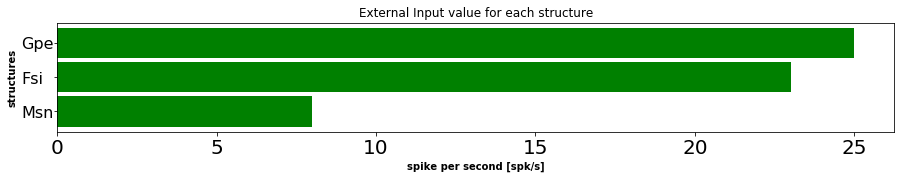

In [30]:
 ## Plotting EXTERNAL INPUTS
    
Inplot(structures,[H['Msn'],H['Gpe'],H['Fsi']],'External Input value for each structure')
plt.show()                                                                                

# 3 - Single neuron activity plotting : all n neurons /!\

In [31]:
 ## Plotting ACTIVITIES over time : all nth neurons of each population on one plot

for k in tqdm( range(0,n) ):    # n plot will be generated for n neurons (resource consuming when n is large!)
                                # Disable that code cell when n is large
    plotting(k,m,'Activity over time: Neuron','Time [ms]','Activity [spk/s]',
             con,connections,value,On=0)
    #plt.savefig('DataFsi/{}/Mn{}.png'.format(timestr,k+1),dpi=72,bbox_inches='tight') # enable to save all figures
    #plt.show()                                                                     # enable to display all figures
    plt.close()                 # Need to close plots to free some memory when too much plots (e.g. 1000 neurons)

100%|██████████| 1/1 [00:00<00:00, 20.84it/s]


# 4 - Single neuron activity plotting : 1 random neuron in each population

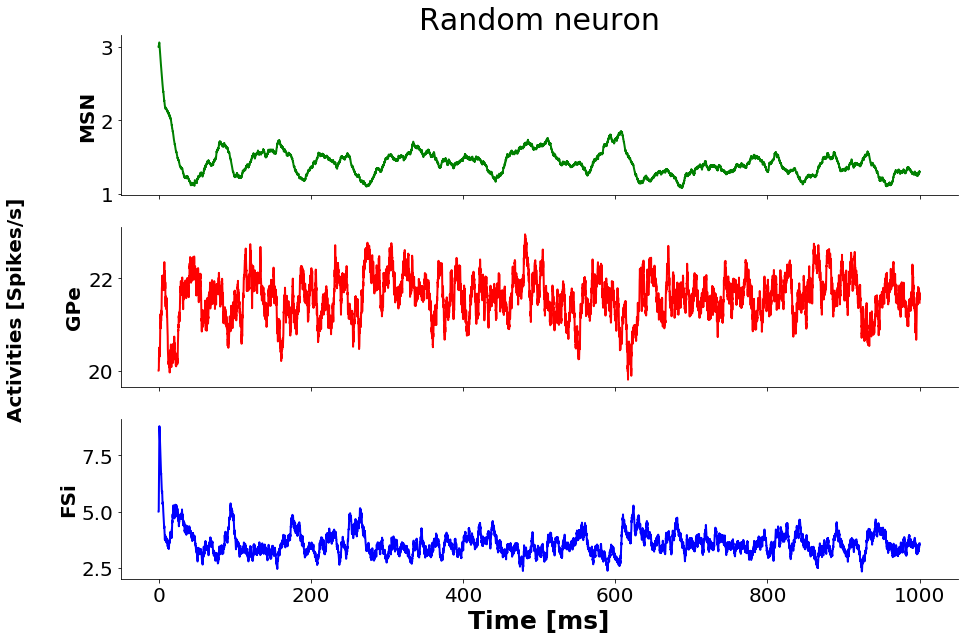

In [32]:
 ## Plotting ACTIVITIES over time : ONE randomly choosen neuron for each populations
    # That plot is dependant of the previous ones. disabling the cell before will disable this one too.

fig = plt.figure(figsize=(15,10))                            # Generate the global frame plot + set its size.


 ## 1st axis Plot ======================================================================
ax1 = plt.subplot(311)                                       # Create a subplot at top position.

ax1.set_title('Random neuron',fontsize=30)                   # Set the title. 
ax1.set_ylabel('MSN',fontsize=20,fontweight='bold')          # Set the y-axis label.
ax1.spines['right'].set_visible(False)                       # Hide right axis.
ax1.spines['top'].set_visible(False)                         # Hide top axis.

plt.plot(time_value * 1000, value['GpeMsn'],'g',linewidth=2) # Plot MSN Activity over time value.
                                                             # Time * 1000 to convert into millisecondes.
plt.setp(ax1.get_xticklabels(), visible=False)               # Make x-tick labels invisible.
# ======================================================================================

 ## 2nd axis Plot ======================================================================   
ax2 = plt.subplot(312, sharex=ax1)                           # Create a subplot at middle position.
                                                             # Share ax1 x-axis with 1st axis plot.
ax2.set_ylabel('GPe',fontsize=20,fontweight='bold')          # Set the y-axis label.
ax2.spines['right'].set_visible(False)                       # Hide right axis.
ax2.spines['top'].set_visible(False)                         # Hide top axis.

plt.plot(time_value * 1000, value['FsiGpe'],'r',linewidth=2) # Plot GPe activity over time value.
                                                             # Time * 1000 to convert into millisecondes.
plt.setp(ax2.get_xticklabels(), visible=False)               # Make x-tick labels invisible.
# ======================================================================================

 ## 3rd axis Plot ======================================================================
ax3 = plt.subplot(313, sharex=ax1)                           # Create a subplot at bottom position.
                                                             # Share ax1 x-axis with 1st axis plot.
ax3.set_ylabel('FSi',fontsize=20,fontweight='bold')          # Set the y-axis label.
ax3.set_xlabel('Time [ms]',fontsize=25,fontweight='bold')    # Set the x-axis label used for all subplots.
ax3.spines['right'].set_visible(False)                       # Hide right axis.
ax3.spines['top'].set_visible(False)                         # Hide top axis.

plt.plot(time_value * 1000, value['MsnFsi'],'b',linewidth=2) # Plot FSi activity over time value.
                                                             # Time * 1000 to convert into millisecondes.
# ======================================================================================

fig.text(0.020, 0.5, "Activities [Spikes/s]",                # Set a vertical label over the y-label
         rotation="vertical", va="center",fontsize=20,fontweight='bold')
   

plt.savefig('DataFsi/{}/randnActivity72.png'.format(timestr),dpi=72,bbox_inches='tight')  
plt.show()                                                                                

# 5 - Mean firing rate plotting

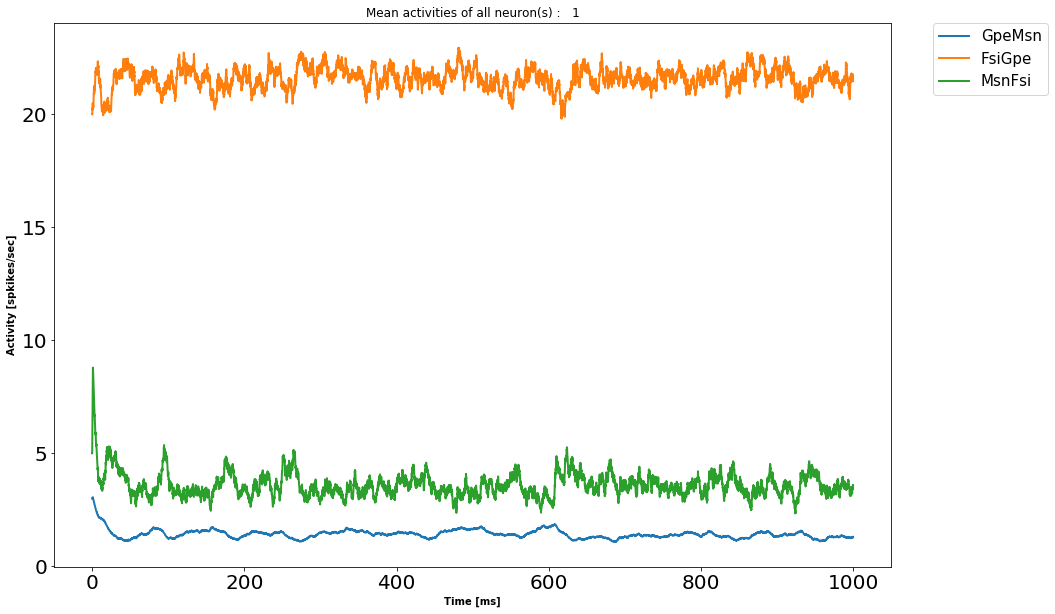

In [33]:
 ## Ploting the mean activity of the n neuron

plotting(n-1, m, 'Mean activities of all neuron(s) :  ', 'Time [ms]','Activity [spkikes/sec]',
         con, connections,Mean,On=1)

plt.savefig('DataFsi/{}/{}_Mean_Activities72.png'.format(timestr,'0'),dpi=72,bbox_inches='tight')
plt.show()                                                                                      

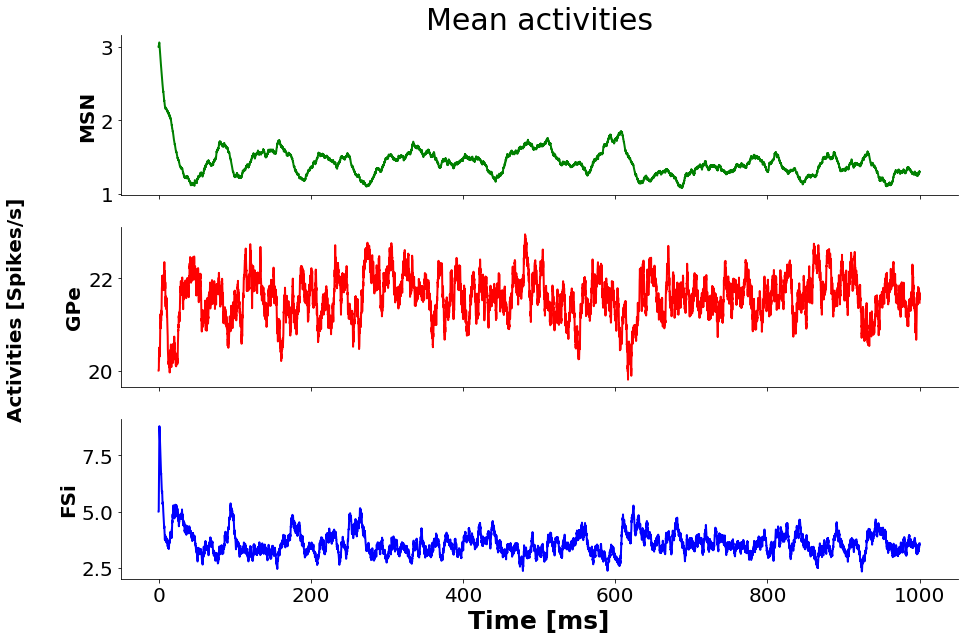

In [34]:
 ## Plotting the mean activity over time of the n neuron in individual frames (2nd view)

fig = plt.figure(figsize=(15,10))                            # Generate the global frame plot + set its size.


 ## 1st axis Plot ======================================================================
ax1 = plt.subplot(311)                                       # Create a subplot at top position.

ax1.set_title('Mean activities',fontsize=30)                 # Set the title.
ax1.set_ylabel('MSN',fontsize=20,fontweight='bold')          # Set the y-axis label.
ax1.spines['right'].set_visible(False)                       # Hide right axis.
ax1.spines['top'].set_visible(False)                         # Hide top axis.

plt.plot(time_value * 1000, Mean['GpeMsn'],'g',linewidth=2)  # Plot MSN Activity over time value.
                                                             # Time * 1000 to convert into millisecondes.
plt.setp(ax1.get_xticklabels(), visible=False)               # Make x-tick labels invisible.
# ======================================================================================

 ## 2nd axis Plot ======================================================================
ax2 = plt.subplot(312, sharex=ax1)                           # Create a subplot at middle position.                  
                                                             # Share ax1 x-axis with 1st axis plot.
ax2.set_ylabel('GPe',fontsize=20,fontweight='bold')          # Set the y-axis label.
ax2.spines['right'].set_visible(False)                       # Hide right axis.
ax2.spines['top'].set_visible(False)                         # Hide top axis.

plt.plot(time_value * 1000, Mean['FsiGpe'],'r',linewidth=2)  # Plot GPe Activity over time value.
                                                             # Time * 1000 to convert into millisecondes.
plt.setp(ax2.get_xticklabels(), visible=False)               # Make x-tick labels invisible.
# ======================================================================================

 ## 3rd axis Plot ======================================================================
ax3 = plt.subplot(313, sharex=ax1)                           # Create a subplot at bottom position.
                                                             # Share ax1 x-axis with 1st axis plot.  
ax3.set_ylabel('FSi',fontsize=20,fontweight='bold')          # Set the y-axis label.
ax3.set_xlabel('Time [ms]',fontsize=25,fontweight='bold')    # Set the x-axis label used for all subplots.
ax3.spines['right'].set_visible(False)                       # Hide right axis.
ax3.spines['top'].set_visible(False)                         # Hide top axis.

plt.plot(time_value * 1000, Mean['MsnFsi'],'b',linewidth=2)  # Plot FSi activity over time value.
                                                             # Time * 1000 to convert into millisecondes.
# ======================================================================================
  
fig.text(0.020, 0.5, "Activities [Spikes/s]",                # Set a vertical label over the y-label
         rotation="vertical", va="center",fontsize=20,fontweight='bold')
   
plt.savefig('DataFsi/{}/MeanActivity72.png'.format(timestr),dpi=72,bbox_inches='tight') 
plt.show()                                                                              

#  6 - Spectrum analysis: DFT

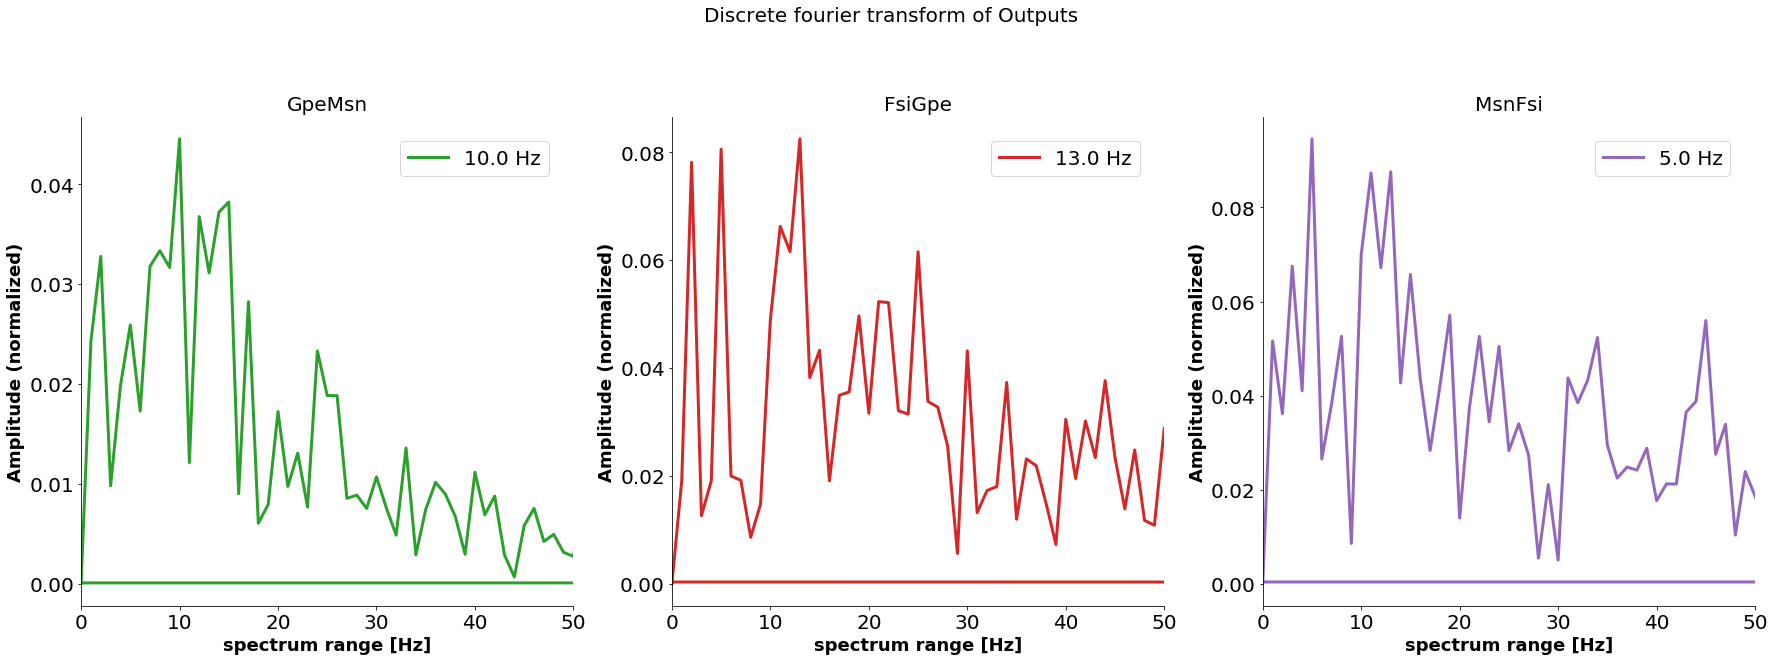

In [35]:
Spectrum() # The function save the plot automatically
plt.show() # Display the plot.

# -  Population analysis

#  1 - Calculate the mean values

In [36]:
 ## Calculating the mean activity of each neuron a each time t (can be easily improved)

moyFsiGpe = []                              # Creating lists to store the mean activities 
moyGpeMsn = []                              # of each individual neuron over time, in each population.
moyMsnFsi = []

supmoyFG = []                               # Creating lists to store the mean activities 
supmoyGM = []                               # of all neurons in one population.
supmoyMF = []

for k in np.arange(0,n,1):                # for all the neuron i, 
    
    moyFsiGpe = []
    moyGpeMsn = []
    moyMsnFsi = []
    
    for t in range(0,n_period):                # for all steps of the simulation,
        
        moyFsiGpe.append(m['FsiGpe'][t][k])    # we add in a list, all the activities over time of each neuron.
        moyGpeMsn.append(m['GpeMsn'][t][k])
        moyMsnFsi.append(m['MsnFsi'][t][k])

    supmoyFG.append(np.mean(moyFsiGpe))     # We take the mean of all mean activities (n neurons)
    supmoyGM.append(np.mean(moyGpeMsn))     # from one population
    supmoyMF.append(np.mean(moyMsnFsi))

#  2 - Plotting the mean values

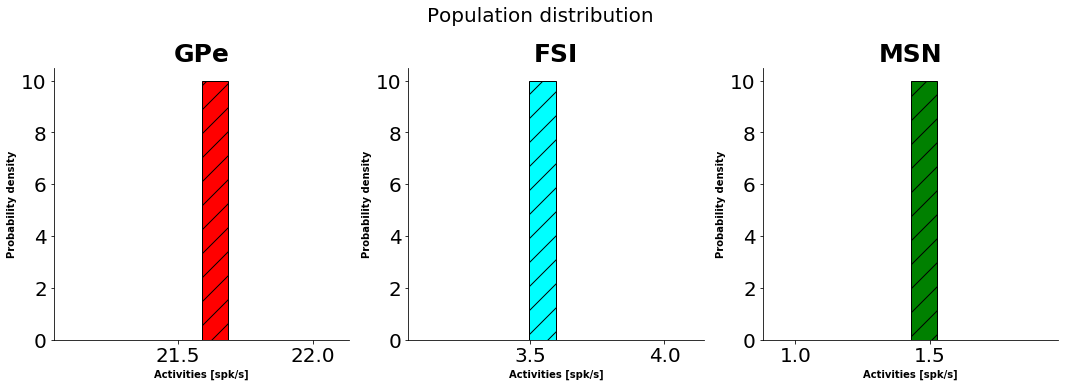

In [37]:
 ## Plotting population distribution analysis

fig, axes = plt.subplots(1, 3, figsize=(18, 5))                       # create one 1x3 plot + set size
fig.suptitle("Population distribution",y=1.05, fontsize=20)           # set global title

 ## 1st axis Plot =======================================================================
axes[0].hist(supmoyFG,normed=True,edgecolor='black',color ='red', hatch = '/')   # Plotting an histogram with mean
axes[0].spines['right'].set_visible(False)                                       # activities of all neurons in
axes[0].spines['top'].set_visible(False)                                         # one population

axes[0].set_title("GPe",fontsize=25,fontweight='bold')
axes[0].set_xlabel("Activities [spk/s]",fontsize=10)
axes[0].set_ylabel('Probability density',fontsize=10)
# =======================================================================================

 ## 2nd axis Plot =======================================================================
axes[1].hist(supmoyMF,normed=True,edgecolor='black',color ='cyan', hatch = '/')  # Plotting an histogram with mean
axes[1].spines['right'].set_visible(False)                                       # activities of all neurons in
axes[1].spines['top'].set_visible(False)                                         # one population

axes[1].set_title("FSI",fontsize=25,fontweight='bold')
axes[1].set_xlabel("Activities [spk/s]",fontsize=10)
axes[1].set_ylabel('Probability density',fontsize=10)
# =======================================================================================

 ## 3rd axis Plot =======================================================================   
axes[2].hist(supmoyGM,normed=True,edgecolor='black',color ='green', hatch = '/') # Plotting an histogram with mean
axes[2].spines['right'].set_visible(False)                                       # activities of all neurons in
axes[2].spines['top'].set_visible(False)                                         # one population

axes[2].set_title("MSN",fontsize=25,fontweight='bold')
axes[2].set_xlabel("Activities [spk/s]",fontsize=10)
axes[2].set_ylabel('Probability density',fontsize=10)
# =======================================================================================

plt.savefig('DataFsi/{}/Dsitribution.png'.format(timestr),dpi=72,bbox_inches='tight')
plt.show()